In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utility
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load dataset
df = pd.read_csv(r"F:\unified\vehicle-price-prediction\data\dataset.csv")

# Preview data
df.head()


,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


In [3]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

,year,price,cylinders,mileage,doors
count,1002.000000,979.000000,897.000000,968.000000,995.000000
mean,2023.916168,50202.985700,4.975474,69.033058,3.943719
std,0.298109,18700.392062,1.392526,507.435745,0.274409
min,2023.000000,0.000000,0.000000,0.000000,2.000000
25%,2024.000000,36600.000000,4.000000,4.000000,4.000000
50%,2024.000000,47165.000000,4.000000,8.000000,4.000000
75%,2024.000000,58919.500000,6.000000,13.000000,4.000000
max,2025.000000,195895.000000,8.000000,9711.000000,5.000000


In [4]:
#Data Cleaning
#Remove Duplicates
df.drop_duplicates(inplace=True)
#Drop Low-Value / High-Noise Columns
drop_cols = [
    'name',
    'description',
    'trim',
    'exterior_color',
    'interior_color'
]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

In [5]:
#Handle Missing Values
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

# Fill numerical columns with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
df.isnull().sum()

make            0
model           0
year            0
price           0
engine          0
cylinders       0
fuel            0
mileage         0
transmission    0
body            0
doors           0
drivetrain      0
dtype: int64

In [6]:
#Feature Engineering
current_year = datetime.now().year

df['vehicle_age'] = current_year - df['year']
df['mileage_per_year'] = df['mileage'] / (df['vehicle_age'] + 1)

# Drop original year column
df.drop(columns=['year'], inplace=True)


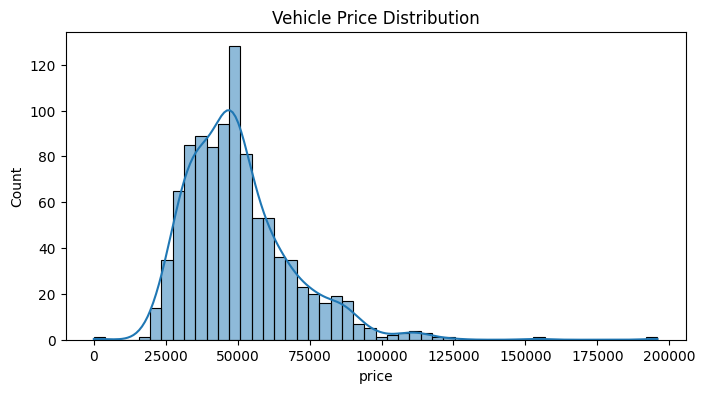

In [7]:
#Exploratory Data Analysis (EDA)
#Price Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Vehicle Price Distribution")
plt.show()

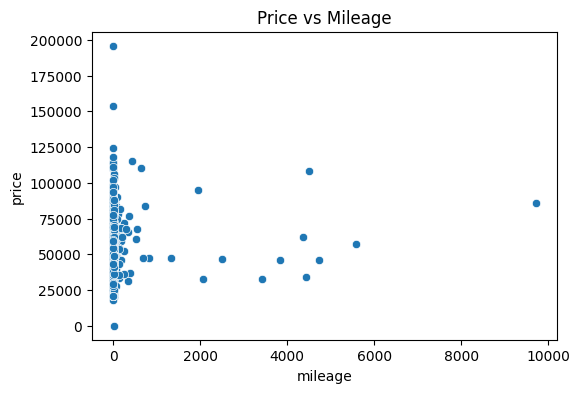

In [8]:
#Price vs Mileage
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['mileage'], y=df['price'])
plt.title("Price vs Mileage")
plt.show()

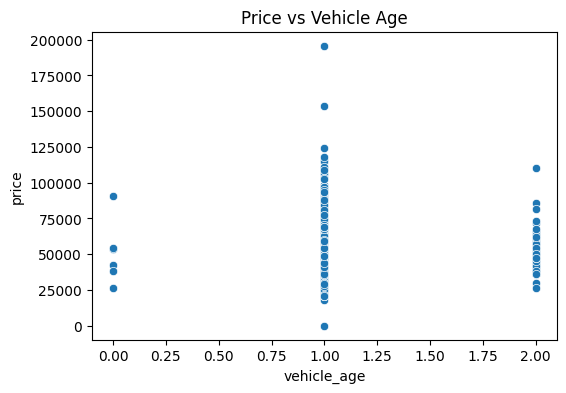

In [9]:
#Price vs Vehicle Age
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['vehicle_age'], y=df['price'])
plt.title("Price vs Vehicle Age")
plt.show()

In [10]:
#Train-Test Split
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
#preprocessing Pipeline
# Identify column types
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [12]:
#modelselection
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)


In [13]:
#ML Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [14]:
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
#Model Evaluation
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance")
print("-----------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")

Model Performance
-----------------
MAE  : 5135.71
RMSE : 8686.46
R²   : 0.786


In [16]:
#Feature Importance 
feature_names = (
    pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .get_feature_names_out(cat_cols)
)

all_features = list(num_cols) + list(feature_names)

importances = pipeline.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df.head(10)

,feature,importance
0,cylinders,0.159134
268,fuel_Gasoline,0.097762
172,model_i7,0.059698
265,fuel_Diesel,0.047115
195,engine_24V GDI DOHC Twin Turbo,0.042765
7,make_BMW,0.035954
316,drivetrain_Front-wheel Drive,0.034401
4,mileage_per_year,0.033816
1,mileage,0.032607
59,model_EQS 450,0.030517


In [17]:
#Predict on New Vehicle
new_vehicle = pd.DataFrame([{
    "make": "Toyota",
    "model": "Camry",
    "engine": "2.5L",
    "cylinders": 4,
    "fuel": "Gasoline",
    "mileage": 30000,
    "transmission": "Automatic",
    "body": "Sedan",
    "doors": 4,
    "drivetrain": "Front-wheel Drive",
    "vehicle_age": 3,
    "mileage_per_year": 10000
}])

predicted_price = pipeline.predict(new_vehicle)
print("Predicted Vehicle Price (USD):", round(predicted_price[0], 2))

Predicted Vehicle Price (USD): 29891.83


In [19]:
import xgboost as xgb
import shap


In [20]:
#XGBoost Pipeline
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])


In [21]:
#Train XGBoost Model
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
#Evaluate XGBoost Model
xgb_preds = xgb_pipeline.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

print("XGBoost Performance")
print("-------------------")
print(f"MAE  : {xgb_mae:.2f}")
print(f"RMSE : {xgb_rmse:.2f}")
print(f"R²   : {xgb_r2:.3f}")

XGBoost Performance
-------------------
MAE  : 4939.26
RMSE : 7941.73
R²   : 0.821


In [23]:
#Prepare Data for SHAP
# Transform training data
X_train_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_train)

# Get feature names
cat_feature_names = (
    xgb_pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .get_feature_names_out(cat_cols)
)

feature_names = list(num_cols) + list(cat_feature_names)

In [31]:
background = X_train_transformed[:100]

def xgb_predict(data):
    return xgb_pipeline.named_steps['model'].predict(data)

explainer = shap.Explainer(
    xgb_predict,
    background,
    feature_names=feature_names
)

shap_values = explainer(X_train_transformed[:50])

shap.summary_plot(
    shap_values,
    X_train_transformed[:50],
    feature_names=feature_names
)


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 318) was passed while the masker expected data of shape (318,).

In [26]:
xgb_trained_model = xgb_pipeline.named_steps['model']
X_train_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed  = xgb_pipeline.named_steps['preprocessor'].transform(X_test)
cat_feature_names = (
    xgb_pipeline.named_steps['preprocessor']
    .transformers_[1][1]
    .get_feature_names_out(cat_cols)
)

feature_names = list(num_cols) + list(cat_feature_names)

